In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [3]:
# load train dataset (todo dataset tem 1309 observações)
df_train = pd.read_csv('datasets/train_titanic.csv')

#### Exibindo os tipos de features, quantidades de observações e features

In [4]:
print(df_train.info())
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
(891, 12)


#### Removendo a identificação da cabine (Cabin) o local de embarque (Embarked), o Ticket, o nome da pessoa (Name) e a coluna binária target (Survived) do dataset de treino. A serie target é a coluna Survived

In [5]:
data, target = df_train.drop(columns = {'Survived','Name', 'Cabin', 'Ticket'}), df_train['Survived']

#### Quantos sobreviveram no conjunto de treino

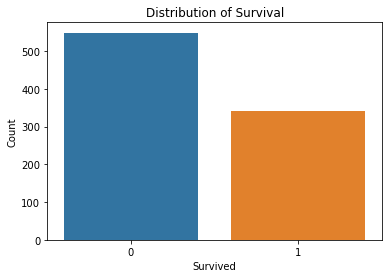

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
## categorical attributes
sns.countplot(data=df_train, x='Survived')

# Add labels and title
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Survival')

# Show the plot
plt.show()

#### Tarefa 1) Acrescente abaixo células para gerar gráfico de frequência de algumas variáveis categóricas similar ao gráfico acima, para as features PClass, Sibsp, Parch, Embarked (local de embarque) 

#### Verificando no conjunto de treino a distribuição entre homens e mulheres que sobreviveram

In [7]:
women = df_train.loc[df_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = df_train.loc[df_train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(f'{sum(women)} Mulheres sobreviventes de {len(women)}: {rate_women}')
print(f'{sum(men)} Homens sobreviventes de {len(men)}: {rate_men}')

233 Mulheres sobreviventes de 314: 0.7420382165605095
109 Homens sobreviventes de 577: 0.18890814558058924


#### Verificando a DISTRIBUIÇÃO de idades no conjunto de treino

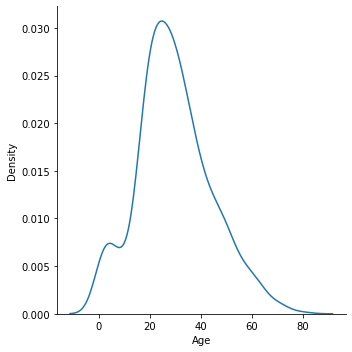

In [8]:
sns.displot(df_train['Age'], kind='kde')

#### Vamos criar um gráfico de barras para entender a distribuição de sobreviventes e não sobreviventes de acordo com a classe e o valor da taxa média

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

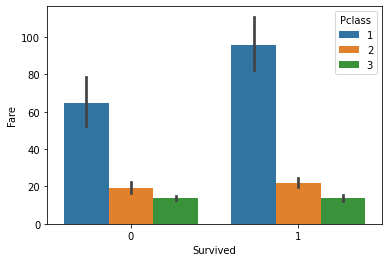

In [9]:
sns.barplot(data=df_train, x='Survived', y='Fare', hue='Pclass')

<AxesSubplot:xlabel='Survived', ylabel='Age'>

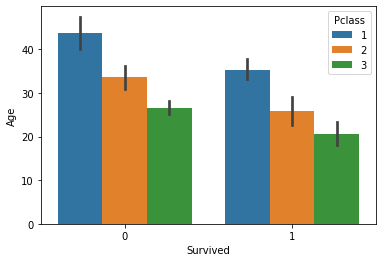

In [10]:
sns.barplot(data=df_train, x='Survived', y='Age', hue='Pclass')

#### Este gráfico pode estar incorreto, pois precisamos ver se há dados faltantes de idade. Caso haja, podemos estabelecer algum critério de preenchimento, como a média das idades

In [11]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# Preencher com a idade média
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())

<AxesSubplot:xlabel='Survived', ylabel='Age'>

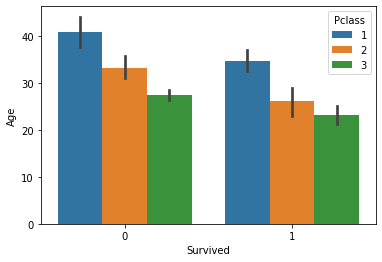

In [13]:
sns.barplot(data=df_train, x='Survived', y='Age', hue='Pclass')

#### Será que a idade é uma boa feature decisória? E o valor da passagem? Vamos procurar identificar as correlações de Pearson das features numéricas com a variável target

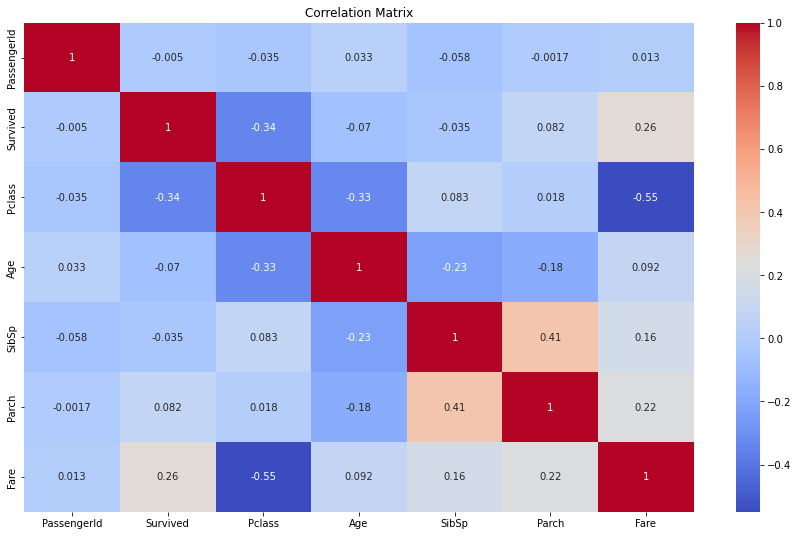

In [14]:
# Calculate correlation matrix for numeric columns only
corr = df_train.corr(method='pearson', min_periods=1)

# Plot the correlation matrix
plt.figure(figsize=(15, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

#### Escolha 1) classe, sexo, número de parentes sanguíneos e não sanguíneos

In [16]:
features = ["Pclass", "Sex", "SibSp", "Parch"] # exemplo de subconjunto de features
# pclass	Ticket class	1 = 1st (upper), 2 = 2nd (middle), 3 = 3rd (lower)
# sibsp: # of siblings The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister
                                                             #Spouse = husband, wife (mistresses and fiancés were ignored)
# parch: # of parents / children aboard the Titanic	                                                             
"""Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them."""

'Parent = mother, father\nChild = daughter, son, stepdaughter, stepson\nSome children travelled only with a nanny, therefore parch=0 for them.'

#### Necessário encoder da feature Sex

In [17]:
X = pd.get_dummies(data[features]) #similar to one_hot_encoding (return a df)
X

,Pclass,SibSp,Parch,Sex_female,Sex_male
0,3,1,0,0,1
1,1,1,0,1,0
2,3,0,0,1,0
3,1,1,0,1,0
4,3,0,0,0,1
...,...,...,...,...,...
886,2,0,0,0,1
887,1,0,0,1,0
888,3,1,2,1,0
889,1,0,0,0,1


#### Vamos testar estas features com o KNN

#### Vamos criar uma função que recebe o modelo/algoritmo, separa o conjunto de treino em treino limitado/validação e obtém a acurácia de validação e depois roda a validação cruzada e obtém a acurácia média e o desvio padrão. O objetivo é verificar se as duas métricas são semelhantes (com dados novos da CV), para diferentes modelos ML de classificação

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
def classify(model):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    print("Accuracy full validation set: %0.2f" % model.score(X_test, y_test))
    
    score = cross_val_score(model, X, target, cv=5, scoring='accuracy')
    print("Mean Accuracy CV: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

In [19]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
classify(knn_model)

Accuracy full validation set: 0.76
Mean Accuracy CV: 0.79 (+/- 0.02)


#### Tarefa 2) Repetir a célula acima para os algoritmos classificadores do sklearn Regressão Logística (LogisticRegression), Árvore de Decisão (DecisionTree), Floresta Aleatória (RandomFlorest), ExtraTreeClassifier, XGBClassifier, CatBoostClassifier. Considerar em cada caso os hiperparâmetros default. Por exemplo, no caso acima poderia ser apenas KNeighborsClassifier(). Escolha o modelo final para predição no conjunto de teste com a menor diferença dos resultados acima

In [22]:
df_test = pd.read_csv('datasets/test_titanic.csv')
print(df_test.shape)

X_test = pd.get_dummies(df_test[features])

#Exemplo, se fosse o KNN o melhor acima:
knn_model.fit(X,target)
y_pred = knn_model.predict(X_test)

# salvar para upload em competições como Kaggle em que o conjunto de teste não possui coluna target
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
output.to_csv('mypredictions.csv', index=False)
print("Submissão salva!")
# https://www.kaggle.com/code/alexisbcook/titanic-tutorial

OSError: [Errno 22] Invalid argument

In [58]:

df_full = pd.read_excel('datasets/gender_submission.csv') 
#df_full.head()
#target_test = df_full.iloc[891:,1]
#target_test



In [57]:
from sklearn.metrics import classification_report
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.67      0.71       312
           1       0.29      0.40      0.33       106

    accuracy                           0.60       418
   macro avg       0.53      0.53      0.52       418
weighted avg       0.64      0.60      0.62       418

